In [10]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Generate batches of tensor image data with real-time data augmentation.
from tensorflow.keras.applications import MobileNetV2 # CNN architecture that works well w/mobile devices as well
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Preprocesses a tensor or Numpy array encoding a batch of images.
from tensorflow.keras.preprocessing.image import img_to_array, load_img 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical # converts a class vector (integers) to a binary class matrix
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from imutils import paths
import cv2
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgrey'

## Preprocessing the data

In [12]:
# init the initial learning rate, number of epochs to train for, and batch size
init_lr = 1e-4
epochs = 40
bs = 32
image_size = (224,224)

In [13]:
DIRECTORY = r"data"
CATEGORIES = ["mask_weared_incorrect","with_mask","without_mask"]

In [14]:
print("[INFO] loading images...")

[INFO] loading images...


In [9]:
# splitfolders.ratio('data',output='split_data', seed=1337, ratio=(.8,.1,.1))

## image_dataset_from_directory Pipeline

In [10]:
# create batch datasets

train_ds = image_dataset_from_directory('data',
                                       validation_split=0.2,
                                       subset='training',
                                       seed=1337,
                                       image_size=image_size,
                                       batch_size=bs)
test_ds = image_dataset_from_directory('data',
                                      validation_split=0.2,
                                      subset='validation',
                                      seed=1337,
                                      image_size=image_size,
                                      batch_size=bs)

Found 8982 files belonging to 3 classes.
Using 7186 files for training.


2021-09-01 20:46:12.474355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-01 20:46:12.474401: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-01 20:46:12.474420: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cf268c828c40): /proc/driver/nvidia/version does not exist
2021-09-01 20:46:12.474706: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 8982 files belonging to 3 classes.
Using 1796 files for validation.


2021-09-01 20:46:12.962611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


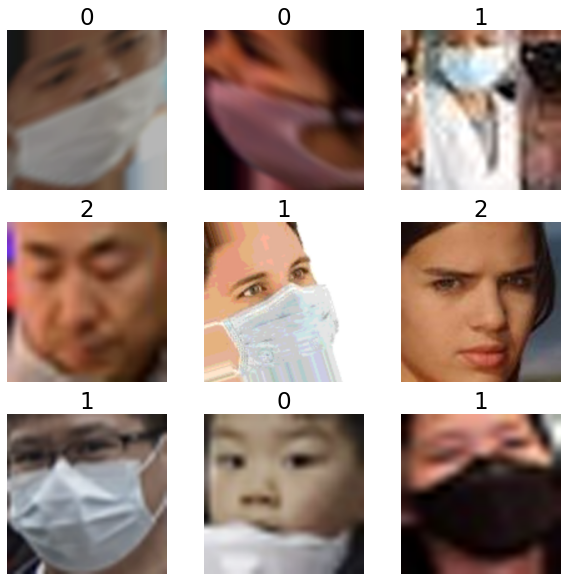

In [11]:
# visualize the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## keras_generator Pipeline

## Model Building w/function

In [15]:
def build_model(num_classes, img_size=224):
    # load MobileNetV2 network, ensuring the head FC (Fully Connected) layer sets are left off
    inputs = Input(shape=(img_size,img_size,3))    
    baseModel = MobileNetV2(input_shape=(img_size,img_size,3),weights="imagenet", include_top=False, input_tensor=inputs)
    
    
    # create the head of the model that will be placed on top of the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    
    headModel = Dense(num_classes, activation="softmax")(headModel)
    
    # place the head FC model on top of the base model (this will become the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

    # lopp over all layers in the base model and freeze them so they will not be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable=False
        
    # compile model
    print("[INFO] compiling model...")
    opt = Adam(lr=init_lr,decay=init_lr / epochs)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [16]:
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2)
    

In [17]:
train = datagen.flow_from_directory('split_data/train', class_mode='categorical',target_size=image_size, batch_size=bs,seed=42)
test = datagen.flow_from_directory('split_data/test',class_mode='categorical',target_size=image_size, batch_size=bs,seed=42)
# val = datagen.flow_from_directory('split_data/val', class_mode='categorical',target_size=image_size,batch_size=bs)

x_train, y_train = next(train)
x_test,y_test = next(test)
# x_val, y_val = next(val)


Found 7185 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [18]:
num_classes = len(CATEGORIES)
model = build_model(num_classes)

# train head of the network
print("[INFO] training head...")
H = model.fit(
        train,
        steps_per_epoch=(len(train) // bs),
        validation_data=(x_test,y_test),
        validation_steps=len(x_test) // bs,
        batch_size=bs,
        epochs=epochs,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  verbose=1,
                                                  patience=4,
                                                  restore_best_weights=True)
)

2021-09-02 17:31:57.223407: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-02 17:31:57.223432: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (atlas-GL753VD): /proc/driver/nvidia/version does not exist
2021-09-02 17:31:57.224101: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9420800/9406464 [==============================] - 2s 0us/step
[INFO] compiling model...
[INFO] training head...


/home/atlas/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-09-02 17:32:01.766772: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2021-09-02 17:32:01.837923: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2021-09-02 17:32:05.426236: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2021-09-02 17:32:05.477333: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2021-09-02 17:32:05.508213: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2021-09-02 17:32:05.537141: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25690112 exceeds 10% of free system memory.


7/7 [==============================] - 11s 1s/step - loss: 1.4081 - accuracy: 0.3571 - val_loss: 1.0030 - val_accuracy: 0.5625
Epoch 2/40
7/7 [==============================] - 7s 1s/step - loss: 1.2725 - accuracy: 0.3884 - val_loss: 0.8920 - val_accuracy: 0.5625
Epoch 3/40
7/7 [==============================] - 7s 897ms/step - loss: 1.1115 - accuracy: 0.4821 - val_loss: 0.8004 - val_accuracy: 0.6250
Epoch 4/40
7/7 [==============================] - 7s 919ms/step - loss: 1.0546 - accuracy: 0.4643 - val_loss: 0.7433 - val_accuracy: 0.6562
Epoch 5/40
7/7 [==============================] - 7s 922ms/step - loss: 0.9286 - accuracy: 0.5714 - val_loss: 0.6819 - val_accuracy: 0.6562
Epoch 6/40
7/7 [==============================] - 6s 884ms/step - loss: 0.9401 - accuracy: 0.5446 - val_loss: 0.6532 - val_accuracy: 0.7188
Epoch 7/40
7/7 [==============================] - 6s 879ms/step - loss: 0.8859 - accuracy: 0.5536 - val_loss: 0.6276 - val_accuracy: 0.7500
Epoch 8/40
7/7 [====================

In [340]:
x_test.shape

(32, 224, 224, 3)

In [33]:
ev = model.evaluate(x_test, batch_size=bs)

1/1 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


1st try: loss 0.6 accuracy .75 <br>
2nd try: loss 0.59 accuracy .77 <br>
3rd try: loss 0.57 accuracy .77

In [19]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=bs)

[INFO] evaluating network...


In [20]:
# for each img in the testing set, we need to find idx of label w/corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# ! DO CLASSIFICATION REPORT

In [21]:
print(classification_report(np.argmax(y_test, axis=1), predIdxs, target_names=['Mask Worn Incorrectly','Mask','No Mask']))

                       precision    recall  f1-score   support

Mask Worn Incorrectly       0.92      0.79      0.85        14
                 Mask       0.80      0.89      0.84         9
              No Mask       0.80      0.89      0.84         9

             accuracy                           0.84        32
            macro avg       0.84      0.85      0.84        32
         weighted avg       0.85      0.84      0.84        32



In [30]:
labels = ['Mask Worn Incorrectly','Mask','No Mask']
cm = sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1), predIdxs, labels =['Mask Worn Incorrectly','Mask','No Mask']))
print(cm)

/home/atlas/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:312: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif np.all([l not in y_true for l in labels]):


ValueError: At least one label specified must be in y_true

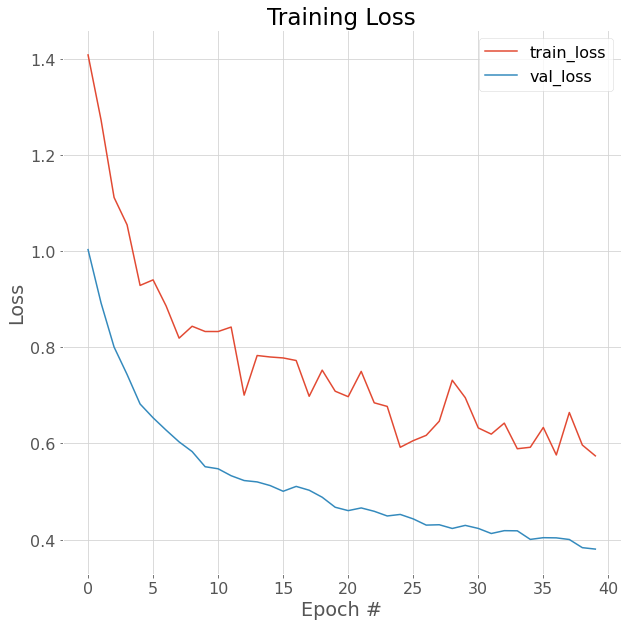

In [28]:
# plot the training loss and accuracy

plt.figure(figsize=(10,10))
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')

plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.savefig("images/train_loss.png")

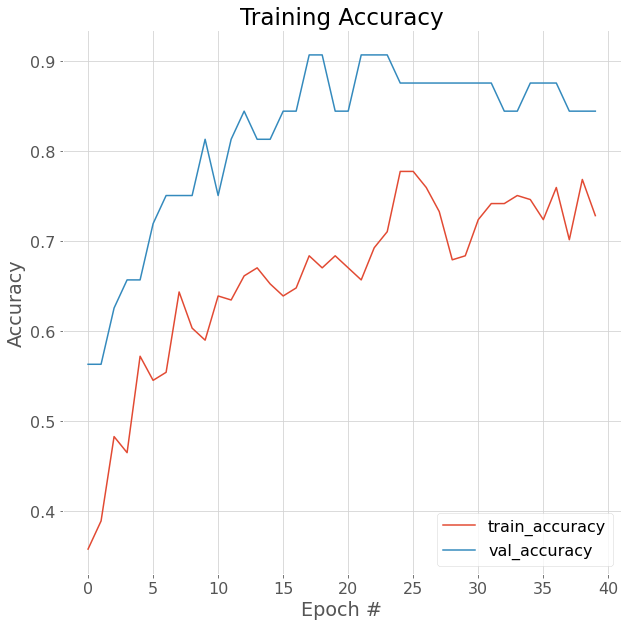

In [27]:
plt.figure(figsize=(10,10))
plt.plot(H.history['accuracy'], label='train_accuracy')
plt.plot(H.history['val_accuracy'], label='val_accuracy')

plt.title('Training Accuracy')
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.savefig("images/train_accuracy.png")


In [29]:
# serialize the model to disk
print('[INFO] saving mask detector model...')
model.save("detect_mask.model", save_format='h5')

[INFO] saving mask detector model...
